In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchsummary
import numpy as np
import matplotlib.pyplot as plt

Things to try:
1. What if I use a larger network?
2. Better normalization with BatchNorm
3. Different learning rates
4. Change architecture to CNN

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [3]:
class Discriminator(nn.Module):
	def __init__(self, img_dim):
		super().__init__()
		self.disc = nn.Sequential(
			nn.Linear(img_dim, 128),
			nn.LeakyReLU(0.1),
			nn.Linear(128, 1),
			nn.Sigmoid()
		)

	def forward(self, x):
		return self.disc(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),              # z_dim is the dimension of noise
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),            # 256 -> 28x28x1=784
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)

In [5]:
lr = 3e-4
z_dim = 64			# 128, 256
img_dim = 28*28*1	# 784
batch_size = 32
num_epochs = 50

In [6]:
disc = Discriminator(img_dim).to(device)
gen = Generator(z_dim, img_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
dataset = datasets.MNIST(root='dataset/', transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

In [8]:
print('Discriminator:')
torchsummary.summary(disc, (img_dim,))

Discriminator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
         LeakyReLU-2                  [-1, 128]               0
            Linear-3                    [-1, 1]             129
           Sigmoid-4                    [-1, 1]               0
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [10]:
print('Generator:')
torchsummary.summary(gen, (z_dim,))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          16,640
         LeakyReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 784]         201,488
              Tanh-4                  [-1, 784]               0
Total params: 218,128
Trainable params: 218,128
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.83
Estimated Total Size (MB): 0.85
----------------------------------------------------------------


In [7]:
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
step = 0

In [8]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]
        
        ### Train Discriminator: max log(D(real)) - log(1-D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)                # retain_graph=True is used to keep the computational graph
        opt_disc.step()
        
        ### Train Generator: min log(1-D(G(z))) -> max(log(D(G(z))))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        # Tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Batch {batch_idx}/{len(loader)}, "
                f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )
            
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)
                
                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                writer_fake.add_scalar("Generator Loss", lossG, global_step=step)
                writer_real.add_scalar("Discriminator Loss", lossD, global_step=step)
                step += 1
                

Epoch [1/50], Batch 0/1875, Loss D: 0.5675, Loss G: 0.6535
Epoch [2/50], Batch 0/1875, Loss D: 0.8539, Loss G: 0.6748
Epoch [3/50], Batch 0/1875, Loss D: 0.8333, Loss G: 0.6672
Epoch [4/50], Batch 0/1875, Loss D: 0.5210, Loss G: 1.0883
Epoch [5/50], Batch 0/1875, Loss D: 0.6940, Loss G: 0.8966
Epoch [6/50], Batch 0/1875, Loss D: 0.3619, Loss G: 1.5184
Epoch [7/50], Batch 0/1875, Loss D: 0.8888, Loss G: 0.7571
Epoch [8/50], Batch 0/1875, Loss D: 0.8139, Loss G: 0.7976
Epoch [9/50], Batch 0/1875, Loss D: 0.7889, Loss G: 0.6524
Epoch [10/50], Batch 0/1875, Loss D: 0.5958, Loss G: 1.0193
Epoch [11/50], Batch 0/1875, Loss D: 0.4926, Loss G: 1.4965
Epoch [12/50], Batch 0/1875, Loss D: 0.5876, Loss G: 0.8446
Epoch [13/50], Batch 0/1875, Loss D: 0.6214, Loss G: 0.8427
Epoch [14/50], Batch 0/1875, Loss D: 0.7075, Loss G: 1.0760
Epoch [15/50], Batch 0/1875, Loss D: 0.6003, Loss G: 1.0207
Epoch [16/50], Batch 0/1875, Loss D: 0.5346, Loss G: 1.3320
Epoch [17/50], Batch 0/1875, Loss D: 0.7140, Loss

In [15]:
import os
from datetime import datetime
os.makedirs("models", exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
torch.save(gen.state_dict(), f"models/gen_{timestamp}.pth")
torch.save(disc.state_dict(), f"models/disc_{timestamp}.pth")

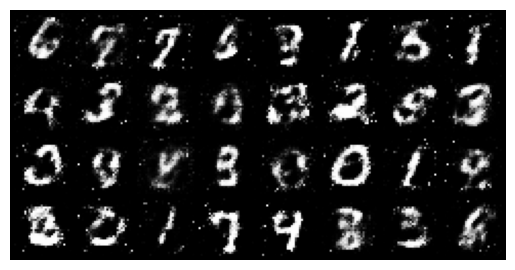

In [14]:
# Testing
gen.eval()
disc.eval()
noise = torch.randn((batch_size, z_dim)).to(device)
fake = gen(noise)
img_grid_fake = torchvision.utils.make_grid(fake.reshape(-1, 1, 28, 28), normalize=True)
plt.imshow(img_grid_fake.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()


References:

1. http://arxiv.org/abs/1406.2661

2. https://youtu.be/OljTVUVzPpM?si=x0iqGhowfRsE8U7l